In [38]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

In [39]:
IMG_SIZE = 28
BATCH_SIZE = 32

In [40]:
(train_ds, test_ds), ds_info = tfds.load(
    "fashion_mnist",
    split=["train", "test"],
    with_info=True,
    as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

In [41]:
size = (IMG_SIZE, IMG_SIZE)
train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
test_ds = test_ds.map(lambda image, label: (tf.image.resize(image, size), label))

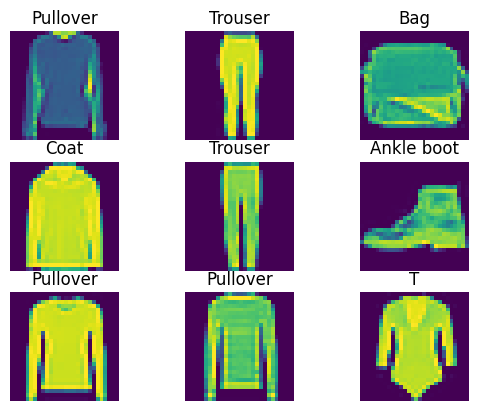

In [42]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[0]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

In [43]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

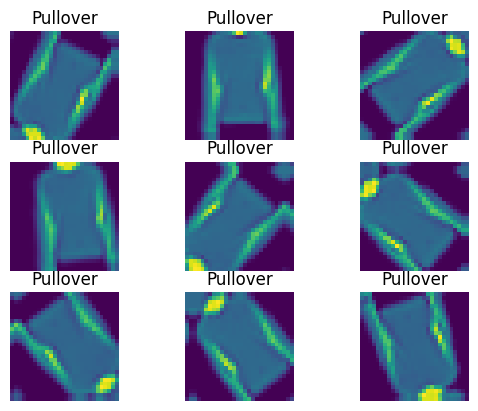

In [45]:
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


In [46]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


train_ds = train_ds.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [47]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    base_model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.4  # Adjust dropout rate
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Add regularizer
    x = layers.Dropout(0.3)(x)  # Add dropout after dense layer
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-4)  # Adjust learning rate
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


In [49]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 7
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds)

Epoch 1/7
1875/1875 [==============================] - 164s 83ms/step - loss: 1.8046 - accuracy: 0.5369 - val_loss: 1.2664 - val_accuracy: 0.6855
Epoch 2/7
1875/1875 [==============================] - 148s 79ms/step - loss: 1.4663 - accuracy: 0.6201 - val_loss: 1.1643 - val_accuracy: 0.7095
Epoch 3/7
1875/1875 [==============================] - 149s 80ms/step - loss: 1.3488 - accuracy: 0.6474 - val_loss: 1.0902 - val_accuracy: 0.7240
Epoch 4/7
1875/1875 [==============================] - 149s 80ms/step - loss: 1.2716 - accuracy: 0.6597 - val_loss: 1.0443 - val_accuracy: 0.7340
Epoch 5/7
1875/1875 [==============================] - 149s 79ms/step - loss: 1.2178 - accuracy: 0.6691 - val_loss: 1.0026 - val_accuracy: 0.7409
Epoch 6/7
1875/1875 [==============================] - 149s 79ms/step - loss: 1.1589 - accuracy: 0.6791 - val_loss: 0.9670 - val_accuracy: 0.7421
Epoch 7/7
1875/1875 [==============================] - 143s 76ms/step - loss: 1.1190 - accuracy: 0.6824 - val_loss: 0.9218 -

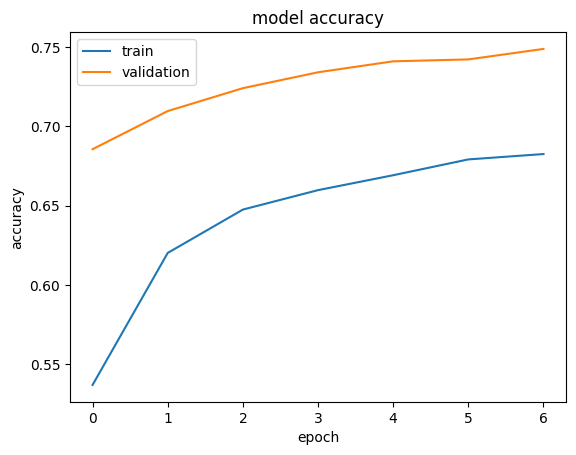

In [50]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

Epoch 1/4
1875/1875 [==============================] - 226s 116ms/step - loss: 1.0799 - accuracy: 0.6923 - val_loss: 0.9217 - val_accuracy: 0.7426
Epoch 2/4
1875/1875 [==============================] - 215s 115ms/step - loss: 1.0598 - accuracy: 0.6959 - val_loss: 0.9012 - val_accuracy: 0.7529
Epoch 3/4
1875/1875 [==============================] - 215s 115ms/step - loss: 1.0364 - accuracy: 0.7033 - val_loss: 0.8948 - val_accuracy: 0.7490
Epoch 4/4
1875/1875 [==============================] - 215s 114ms/step - loss: 1.0239 - accuracy: 0.7084 - val_loss: 0.8841 - val_accuracy: 0.7544


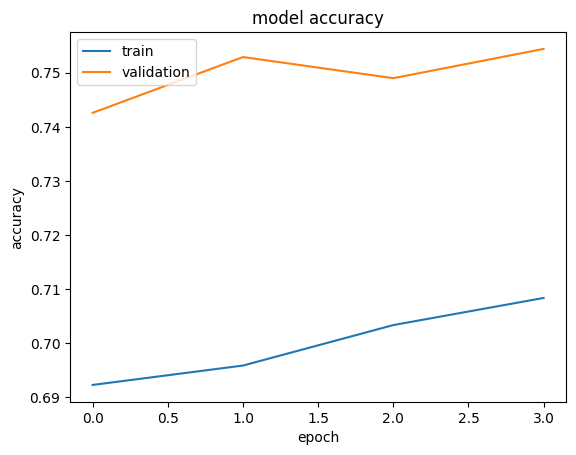

In [51]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 4  # @param {type: "slider", min:4, max:10}
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds)
plot_hist(hist)

In [55]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


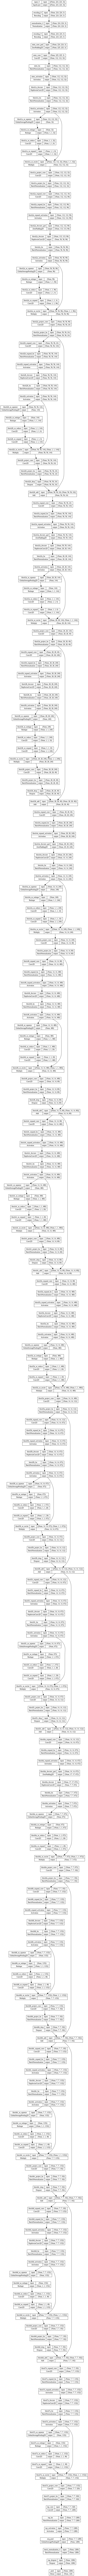

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [54]:
NUM_CLASSES

10